In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install music21
!pip install pydot
!pip install graphviz
!pip install keras-tuner

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import glob
from music21 import converter, instrument, note, chord, stream
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation, Bidirectional, Input, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import time


In [ ]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

def read_midi_files(midi_path, max_processing_time=10, max_files=100):
    notes = []
    file_count = 0
    for path in midi_path:
        for file in glob.glob(f"{path}/*.mid"):
            if file_count >= max_files:
                break
            start_time = time.time()
            try:
                print(f"Attempting to parse {file}")
                midi = converter.parse(file)
                elapsed_time = time.time() - start_time
                if elapsed_time > max_processing_time:
                    print(f"Skipped {file} - Elapsed Time: {elapsed_time} seconds")
                    continue
                s2 = instrument.partitionByInstrument(midi)
                if not s2:
                    print(f"Skipped {file} - Unable to determine instrument")
                    continue
                print(f"Parsing {file} - Elapsed Time: {elapsed_time} seconds")
                notes_count = 0
                for part in s2.parts:
                    notes_to_parse = part.recurse()
                    for element in notes_to_parse:
                        if isinstance(element, note.Note):
                            notes.append(str(element.pitch))
                            notes_count += 1
                        elif isinstance(element, chord.Chord):
                            notes.append('.'.join(str(n) for n in element.normalOrder))
                            notes_count += 1
                file_count += 1
            except Exception as e:
                print(f"Error parsing {file}: {e}")
    return notes


In [ ]:
def prepare_sequences(notes, n_vocab, sequence_length=100):
    if not notes:
        raise ValueError("No notes were parsed from the files. Please check the MIDI files and paths.")
    pitchnames = sorted(set(item for item in notes))
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    network_input = []
    network_output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])
    n_patterns = len(network_input)
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    network_input = network_input / float(n_vocab)
    network_output = to_categorical(network_output)
    split = int(n_patterns * 0.8)
    train_input, val_input = network_input[:split], network_input[split]
    train_output, val_output = network_output[:split], network_output[split]

    return train_input, train_output, val_input, val_output


In [ ]:
def create_network(network_input, n_vocab):
    model = Sequential()
    model.add(Input(shape=(network_input.shape[1], network_input.shape[2])))
    model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.004))))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.7))
    model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.004))))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.7))
    model.add(Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.004))))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.7))
    model.add(Dense(128, kernel_regularizer=l2(0.004)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.7))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))

    optimzr = Adam(learning_rate=0.000001, beta_1=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=optimzr)
    plot_model(model, to_file='/content/model2.png', show_shapes=True, show_layer_names=True)
    return model


In [ ]:
def generate_notes(model, network_input, pitchnames, n_vocab, temperature=1.4):
    start = np.random.randint(0, len(network_input)-1)
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    pattern = network_input[start]
    prediction_output = []

    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)
        prediction = model.predict(prediction_input, verbose=0)
        prediction = np.log(prediction + 1e-8) * (temperature / 4)
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        prediction = prediction / np.sum(prediction)
        index = np.argmax(np.random.multinomial(1, prediction.flatten(), 1))
        result = int_to_note[index]
        prediction_output.append(result)
        pattern = np.append(pattern, index)
        pattern = pattern[1:len(pattern)]

    return prediction_output


In [ ]:
def create_midi(prediction_output, output_path='/content/sample_data/test_output.mid'):
    offset = 0
    output_notes = []
    for pattern in prediction_output:
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = [note.Note(int(current_note)) for current_note in notes_in_chord]
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            output_notes.append(new_note)
        offset += 1.0
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=output_path)


In [ ]:
midi_path = ['/content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0']
notes = read_midi_files(midi_path)
n_vocab = len(set(notes))

Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0866b9ed0ca6465ef0ad229086b8869c.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0866b9ed0ca6465ef0ad229086b8869c.mid - Elapsed Time: 5.042632102966309 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/038e4f7cc800a38d816e699e3f723eef.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/038e4f7cc800a38d816e699e3f723eef.mid - Elapsed Time: 6.4093101024627686 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/02b953e03d7c2e5ff0795a84e9feff25.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/02b953e03d7c2e5ff0795a84e9feff25.mid - Elapsed Time: 9.674576044082642 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/03c638d7ab4330261cf1290c9a2d8acf.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/03c638d7ab4330261cf1290c9a2d8acf.mid - Elapsed Time: 1.171616554260254 seconds
Attempting to p

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'H\xd4\xecI TI\xca\xecC'>; getting generic Instrument
  warnings.warn(


Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/086de66e9a353dc7ed5792f613e0d119.mid - Elapsed Time: 5.853634357452393 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0ea2c0760b4e30954b4ade28a463ae2d.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0ea2c0760b4e30954b4ade28a463ae2d.mid - Elapsed Time: 4.504960060119629 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/052c87db8c73bd9e6fc0330ab9378507.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'\xc7\xe0 \xef\xee\xeb\xf7\xe0\xf1\xe0 \xe4\xee \xe2\xe5\xf1\xed\xfb'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'\xf1\xeb\xee\xe2\xe0: \xce\xeb\xe5\xe2 \xcd.'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'\xec\xf3\xe7\xfb\xea\xe0: \xd4\xe5\xeb\xfc\xf6\xec\xe0\xed \xce.'>; getting generic Instrument
  warnings.warn(


Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/052c87db8c73bd9e6fc0330ab9378507.mid - Elapsed Time: 8.468430519104004 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0873e3174a1736ec0dc43f55264f322e.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0873e3174a1736ec0dc43f55264f322e.mid - Elapsed Time: 5.079997777938843 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/02820dfbd2314a096b22a02ef001f2e5.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/02820dfbd2314a096b22a02ef001f2e5.mid - Elapsed Time: 2.9016799926757812 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/07e5206a491ab691ec9ec55838ecd457.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/07e5206a491ab691ec9ec55838ecd457.mid - Elapsed Time: 3.5086920261383057 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0dd66802480bc4a609df3a42995799f7.mid
Parsing /conte

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=19, channel=None, data=b'Sequenced by Ted Keener \xa9199'>; getting generic Instrument
  warnings.warn(


Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0fdf460e17aec4f65a6e4a797ecb19e1.mid - Elapsed Time: 4.124907970428467 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/07c88a0a0ed992cb4eb77ac404fad93c.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/07c88a0a0ed992cb4eb77ac404fad93c.mid - Elapsed Time: 9.516258239746094 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/07733909cd37ddc7f8879eca885ccc61.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/07733909cd37ddc7f8879eca885ccc61.mid - Elapsed Time: 5.3009209632873535 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0d5dbe55b52b430466c3953253370cb8.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0d5dbe55b52b430466c3953253370cb8.mid - Elapsed Time: 5.052251815795898 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/016c66e35b1aeb3259e59882a87d82e2.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'\xbf\xc6\xaf\xb8\xa5\xbb\xde\xa5\xcd\xaf\xbc\xde\xce\xaf\xb8\xde\xa2STAR LIGHT ZONE\xa3'>; getting generic Instrument
  warnings.warn(


Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/016c66e35b1aeb3259e59882a87d82e2.mid - Elapsed Time: 2.514508008956909 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0faba858e39699a752abc1a742852c8e.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0faba858e39699a752abc1a742852c8e.mid - Elapsed Time: 1.6083428859710693 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0b035a2bfc94c6d118e6c55c335c6692.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0b035a2bfc94c6d118e6c55c335c6692.mid - Elapsed Time: 2.8985369205474854 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0b114c968df4ffd32f12eace81f51d53.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0b114c968df4ffd32f12eace81f51d53.mid - Elapsed Time: 1.526503324508667 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/03132735966a65959ebee8f1781d7fa3.mid
Parsing /conte

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=19, channel=None, data=b'Encarnaci\xf3n/Paraguay'>; getting generic Instrument
  warnings.warn(


Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0af88169bd61d1d31c026377a75e024c.mid - Elapsed Time: 7.8278727531433105 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/039a167a42a9908357a5731899e93e37.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/039a167a42a9908357a5731899e93e37.mid - Elapsed Time: 3.5837526321411133 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0f2c384114be510ce65880b8e1d240ed.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0f2c384114be510ce65880b8e1d240ed.mid - Elapsed Time: 3.3637232780456543 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0cf2e665809b97069d378a69943e71e3.mid
Parsing /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/0cf2e665809b97069d378a69943e71e3.mid - Elapsed Time: 1.2725889682769775 seconds
Attempting to parse /content/drive/MyDrive/CSE0471/lmd_full/lmd_full/0/004ffe87d8c5028b3a314c3d63648d45.mid
Parsing /con

Epoch 1/200
2097/2097 [==============================] - ETA: 0s - loss: 10.9257
Epoch 1: val_loss improved from inf to 10.60816, saving model to /content/model_weights.h5
2097/2097 [==============================] - 77s 31ms/step - loss: 10.9257 - val_loss: 10.6082 - lr: 1.0000e-06
Epoch 2/200
2097/2097 [==============================] - ETA: 0s - loss: 10.8303
Epoch 2: val_loss improved from 10.60816 to 10.53714, saving model to /content/model_weights.h5
2097/2097 [==============================] - 64s 30ms/step - loss: 10.8303 - val_loss: 10.5371 - lr: 1.0000e-06
Epoch 3/200
2097/2097 [==============================] - ETA: 0s - loss: 10.7354
Epoch 3: val_loss improved from 10.53714 to 10.46876, saving model to /content/model_weights.h5
2097/2097 [==============================] - 64s 30ms/step - loss: 10.7354 - val_loss: 10.4688 - lr: 1.0000e-06
Epoch 4/200
2097/2097 [==============================] - ETA: 0s - loss: 10.6405
Epoch 4: val_loss improved from 10.46876 to 10.40013, sav

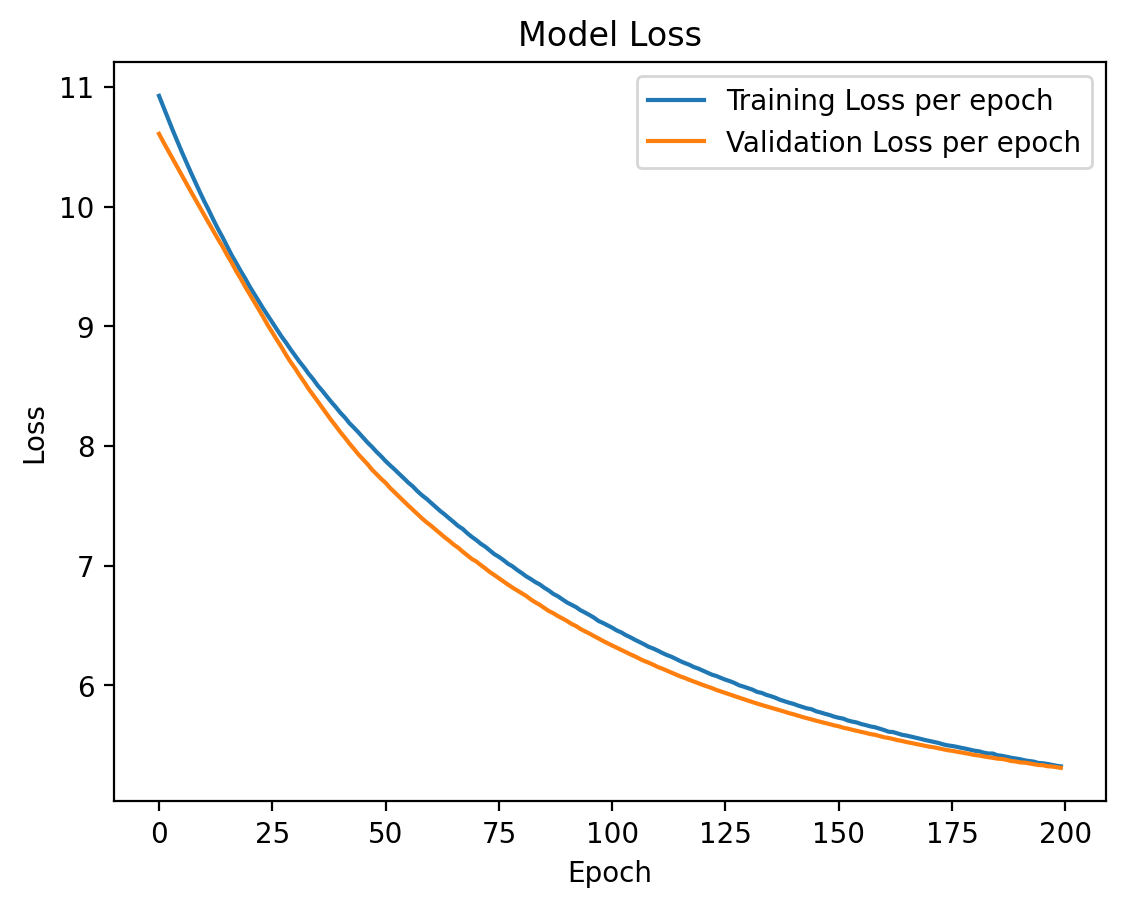

In [ ]:
train_input, train_output, val_input, val_output = prepare_sequences(notes, n_vocab)
model = create_network(train_input, n_vocab)
history = LossHistory()
checkpoint = ModelCheckpoint('/content/model_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss",
    factor=0.2,
    patience=2,
    verbose=1,
    mode="min",
    min_delta=0.001,
    cooldown=1,
    min_lr=1e-15)
model.fit(train_input, train_output, validation_data=(val_input, val_output), epochs=200, batch_size=64, callbacks=[history, checkpoint, early_stopping,reduce_lr])

plt.plot(history.losses, label='Training Loss per epoch')
plt.plot(history.val_losses, label='Validation Loss per epoch')
plt.legend()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

pitchnames = sorted(set(item for item in notes))
prediction_output = generate_notes(model, train_input, pitchnames, n_vocab)
create_midi(prediction_output)
